In [354]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view as sliding_window
plt.rcparams = {"fontsize": 16} 

fig_params = {"dpi": 100, "figsize": (7, 7)}

In [76]:
# Функция действительных значений системы наблюдения ----------------------
def F(t, alpha = 0):
    result = 0
    for n in np.arange(1, K + 1):
        result += np.cos(k * d * n * (t - alpha))
    return result * 2 * ND + ND


# Функция комплексных значений системы наблюдения -------------------------
def Fexp(t, alpha = 0):
    result = 0 + 0j
    for n in np.arange(0, K):
        result += np.exp(-1j * (k * d * (n - K) * (t - alpha))) + \
        np.exp(1j * (k * d * (n - K) * (t - alpha))) 
    return result * ND + ND


# Функция точечного источника сигнала для обнаружения ---------------------
def gauss_func(x, mean=0, var=1):
    return 1/(np.pi * 2 * np.sqrt(var)) * np.exp(-(x - mean)**2/(2 * var))


# Функция комплексной системы точечных целей ------------------------------
def signal_func(x, pos = [0.15, 0.45], var = 0.000001, magnitude = 600):
    pos = np.array(pos)
    var = np.array(var)
    signal = np.zeros_like(x)
    for idx, target in enumerate(pos):
        signal += gauss_func(x, target, var)
    return signal / np.max(signal) * magnitude


# Подынтегральная часть элемента системы наблюдения -----------------------
def integrand_Cn(t, n = 1):
    return np.cos(k * d * n * t) * Idel(t)


# Функция взятия интеграла функции ----------------------------------------
def integral_of_func(func, lower = -1, upper = 1, N = 1000, **kwargs):
    h = (upper - lower) / N
    array_1d = np.arange(lower + h, upper + h, h)
    result = np.sum(func(array_1d, **kwargs) * h)
    return result 


# Векторизация взятия интеграла от функции --------------------------------
int_func = np.vectorize(integral_of_func)


# Взвешивение элементов системы наблюдения --------------------------------
def CnU(x, Cn):
    result = 0
    for n, c in enumerate(Cn[1:]):
        result += c * np.exp(-1j * (k * d * (n + 1) * (x))) + c * np.exp(1j * (k * d * (n + 1) * (x)))
    return result + Cn[0] * np.exp(1j * (k * d * (0) * (x)))


# Метрики качества аппроксимации ------------------------------------------
def rel_squared_error(x, y):
    return np.sum((x - y) ** 2) / np.sum(x**2)

def rel_abs_error(x, y):
    return np.sum(np.abs(x - y)) / np.sum(np.abs(x))

def MAE(x, y):
    return np.sum(np.abs(x - y)) / x.shape[0]

def MSE(x, y):
    return np.sum(np.power(x - y, 2)) / x.shape[0]


# Функция поиска максимумов ------------------------------------------------
def find_maxes(array, filter_maxes = False, filter_level = 1/np.sqrt(2)):
    maxes_pos = []
    maxes_values = []
    for idx, element in enumerate(array[1:-1]):
        if (np.real(element) > np.real(array[idx])) and (np.real(element) > np.real(array[idx + 2])):
            maxes_pos.append(idx + 1)
            maxes_values.append(element)
        
    maxes_pos = np.array(maxes_pos)
    maxes_values = np.array(maxes_values)
    
    if filter_maxes:
        indexes = np.where(maxes_values > np.max(maxes_values) * filter_level)[0]
        maxes_pos = maxes_pos[indexes]
        maxes_values = maxes_values[indexes]
        
    return (np.array(maxes_pos), np.array(maxes_values))

In [444]:
# Количество приемных устройств
K = 20

# Расстояние между приемниками
d = 0.7
d1 = 2 * np.pi * d


M = 2 * K

# k - волновое число
k = 2 * np.pi

# ND
ND = 100 / (2 * K + 1)
ND = 1

# Один радиан в градусах
rad_in_grad = 180 / np.pi 

# Отход от центра наблюдения целей
s = 1/ (M)
s1 = 1.4 * s
dt = 0.1 * s
ds = 0.2 * s
ds1 = 0.005 * s1
sss = 0.01

# Сетки
dtn = np.arange(-s, s + dt, dt)
a = np.arange(-s1, s1 + ds1, ds1)
a1 = np.arange(0, 0.125 * k + ds, ds)

In [455]:
magnitude = 600
targets = [-0.01, 0.01]

# Функция распределения целей в угловом разрешении ------------------------
Idel = lambda t: signal_func(t, pos = targets, magnitude = magnitude)


def integrand(t, alpha):
    return np.real(Fexp(t - alpha)) * Idel(t)


def U00(a):
    return integrate.quad(integrand, -s1, s1, args = (a, ))[0]


vec_U00 = np.vectorize(U00)



Cn_real = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = np.arange(0, K+1))
Result_Real = CnU(a, Cn_real)

In [456]:
targets

[-0.01, 0.01]

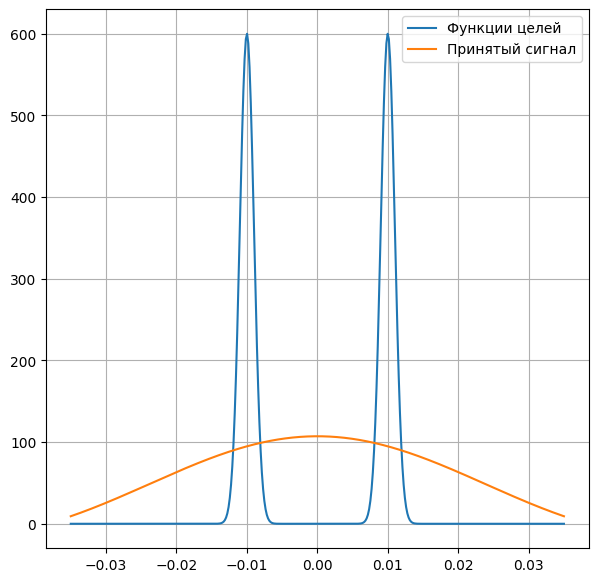

In [457]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, np.real(Result_Real), label = "Принятый сигнал")
plt.legend()
plt.grid()
plt.show()

In [448]:
NP = 200
NPa = np.arange(0, NP + 1)

In [449]:
Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa)

In [450]:
C = Cn[:K+1]
CR = Cn[K+1:]

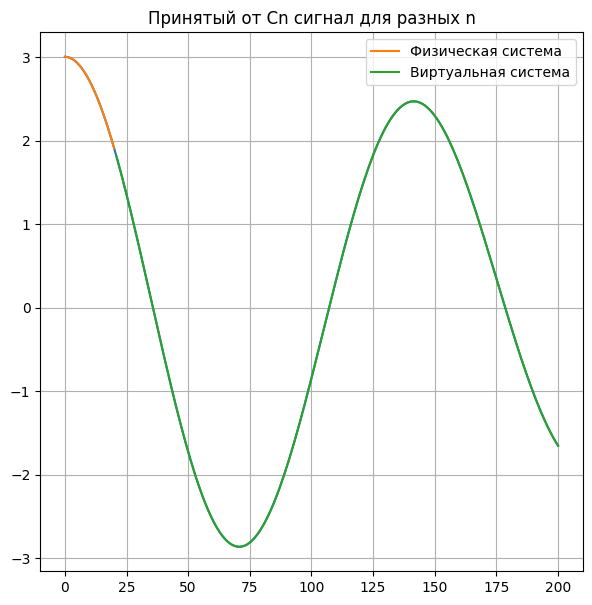

In [452]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.legend()
plt.grid()

In [397]:
Res = CnU(a, Cn)

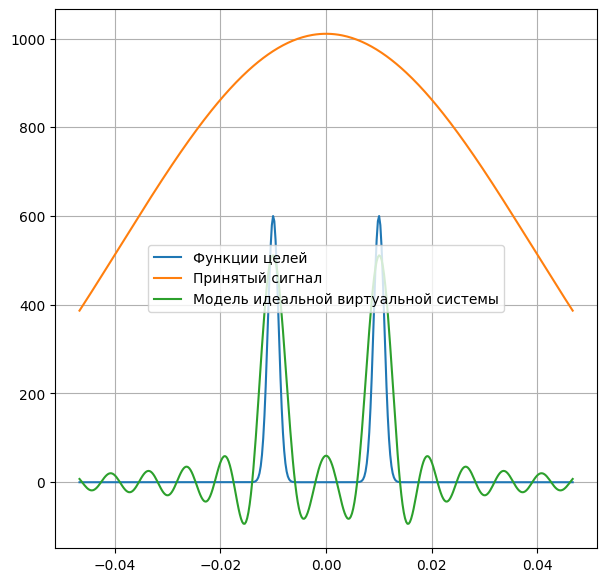

In [398]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Res), label = "Модель идеальной виртуальной системы")
plt.legend()
plt.grid()
plt.show()

## Модель затухающих колебаний

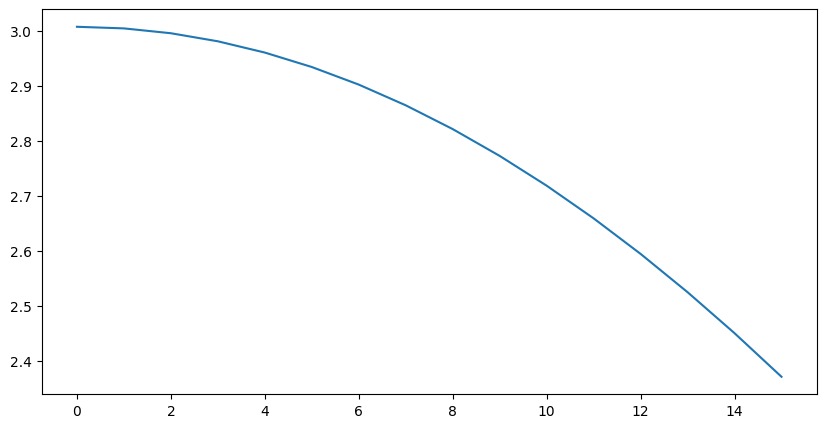

In [399]:
signal = lambda x, A, alpha, beta, epsilon: A * np.exp(alpha * x) * np.sin(beta * x + epsilon)
data = np.vstack([NPa[:K+1], C])

plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.show()

In [400]:
def grad_signal(x, data, A, alpha, beta, epsilon, clip = 255):
    grad = np.zeros(4)
    errors = signal(x, A, alpha, beta, epsilon) - data
    grad[0] = np.sum(errors * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[1] = np.sum(errors * A * x * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[2] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon) * x)
    grad[3] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon))
    return np.clip(grad / len(x), -clip, clip)

In [401]:
params_0 = np.array([data[1, 0], 0, 0 , 1.57])
params = np.zeros(4)
n_steps = 20000
speed = 0.001

num_of_data = data.shape[1]
batch_size = num_of_data // 1

for step in np.arange(n_steps):
    for start_index in range(0, num_of_data, batch_size):
        x_batch = data[0, start_index:start_index + batch_size]
        y_batch = data[1, start_index:start_index + batch_size]
        params = params_0 - speed * grad_signal(x_batch, y_batch, 
                                                params_0[0],
                                                params_0[1],
                                                params_0[2],
                                                params_0[3])
    params_0 = params

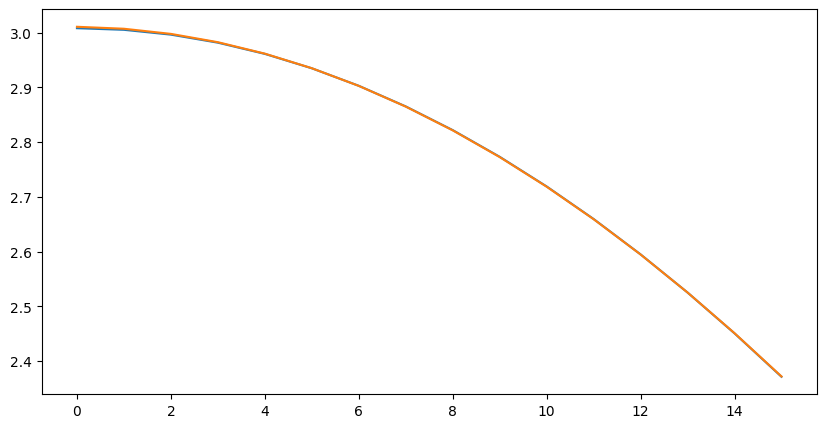

array([ 3.01056416e+00, -1.85450424e-04, -4.39189552e-02,  1.56984133e+00])

In [402]:
plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.plot(data[0], signal(data[0], params[0], params[1], params[2], params[3]))
plt.show()
params

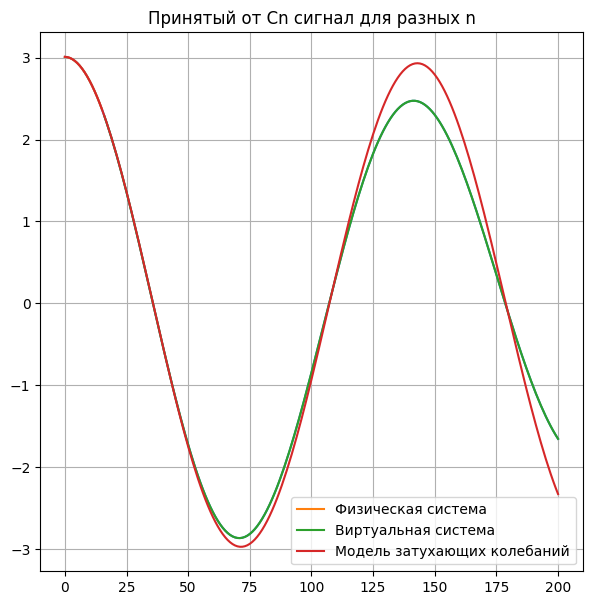

In [403]:
Cn_model = signal(NPa, params[0], params[1], params[2], params[3])

plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, Cn_model,
        label = "Модель затухающих колебаний")
plt.legend()
plt.grid()

In [404]:
print(f"Относительная ошибка по квадратам: {rel_squared_error(Cn, Cn_model)}")
print(f"Относительная ошибка по модулям: {rel_abs_error(Cn, Cn_model)}")
print(f"Средний модуль ошибки: {MAE(Cn, Cn_model)}")
print(f"Средний квадрат ошибки: {MSE(Cn, Cn_model)}")

Относительная ошибка по квадратам: 0.017347268815488898
Относительная ошибка по модулям: 0.10294940348215177
Средний модуль ошибки: 0.1701998415244328
Средний квадрат ошибки: 0.060386683911898394


## Моделирование приемной системы

In [405]:
Result = CnU(a, Cn_model)

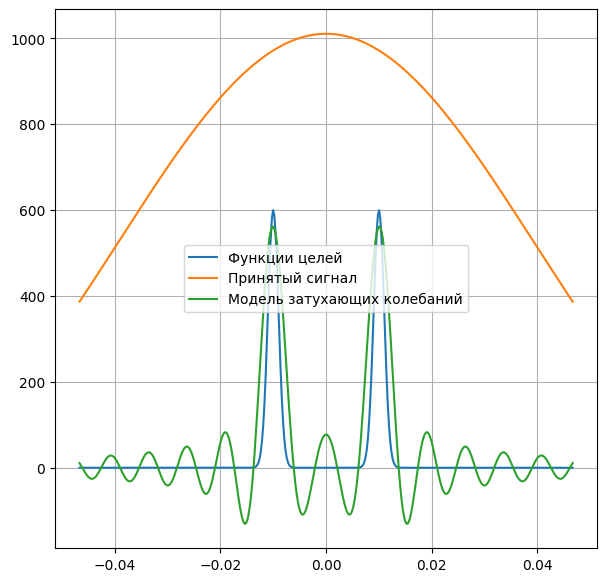

In [406]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result), label = "Модель затухающих колебаний")
plt.legend()
plt.grid()
plt.show()

## Полносвязная нейронная сеть

In [407]:
from sklearn.neural_network import MLPRegressor

In [408]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10), random_state=1, activation = "tanh")

In [409]:
regr.fit(data[0].reshape(-1, 1), data[1])

MLPRegressor(activation='tanh', alpha=1e-05, hidden_layer_sizes=10,
             random_state=1, solver='lbfgs')

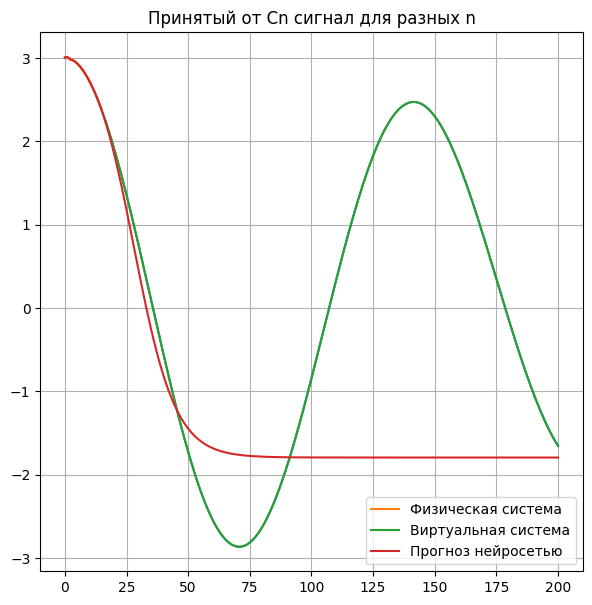

In [411]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, regr.predict(NPa.reshape(-1, 1)), label = "Прогноз нейросетью")
plt.legend()
plt.grid()

In [412]:
Cn_ff = regr.predict(NPa.reshape(-1, 1))

In [413]:
Result_ff = CnU(a, Cn_ff)

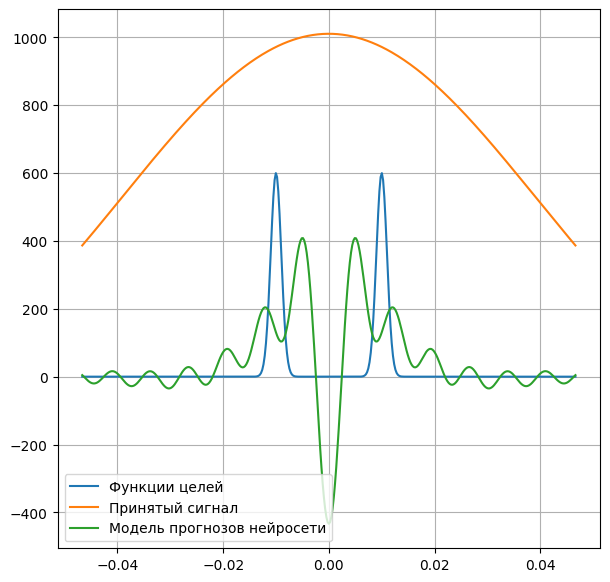

In [414]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result_ff), label = "Модель прогнозов нейросети")
plt.legend()
plt.grid()
plt.show()

## pytorch нейронная сеть siren

In [415]:
import torch
from torch import nn
from siren_pytorch import SirenNet

net = SirenNet(
    dim_in = 1,                        # input dimension, ex. 2d coor
    dim_hidden = 40,                  # hidden dimension
    dim_out = 1,                       # output dimension, ex. rgb value
    num_layers = 2,                    # number of layers
    final_activation = nn.Identity(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 0.1 # different signals may require different omega_0 in the first layer - this is a hyperparameter
)

In [416]:
epochs = 2000
alpha = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr = alpha)
loss_func = nn.MSELoss()

data_torch_x = torch.tensor(data[0].reshape(-1, 1), dtype=torch.float)
data_torch_y = torch.tensor(data[1].reshape(-1, 1), dtype=torch.float)

In [417]:
data_torch_x

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.]])

In [418]:
for iter in range(0, epochs):
    optimizer.zero_grad()
    predictions = net(data_torch_x)
    loss = loss_func(predictions, data_torch_y)
    loss.backward()
    optimizer.step()

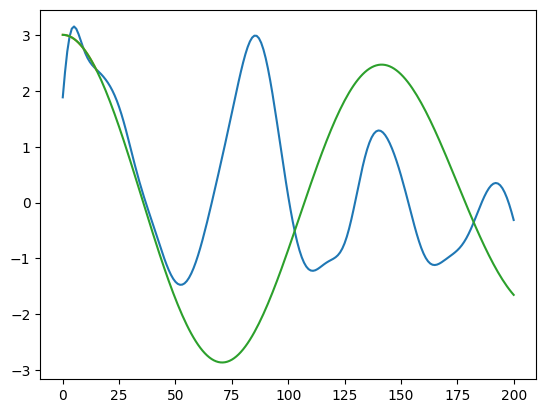

In [419]:
NPa_torch = torch.tensor(NPa.reshape(-1, 1), dtype = torch.float)

plt.plot(net(NPa_torch).detach())
plt.plot(data_torch_y)
plt.plot(Cn)

In [420]:
Cn_siren = np.array(net(NPa_torch).detach()).reshape(-1)

In [421]:
Result_siren = CnU(a, Cn_siren[:70])

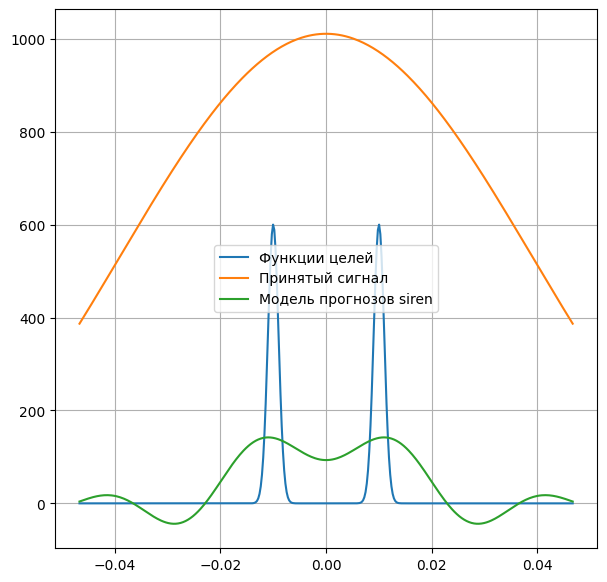

In [422]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result_siren), label = "Модель прогнозов siren")
plt.legend()
plt.grid()
plt.show()

## Тюнинг выборки

In [423]:
data

array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        ],
       [ 3.00795393,  3.00501598,  2.99620808,  2.98154813,  2.96106588,
         2.93480292,  2.90281256,  2.86515972,  2.82192083,  2.77318359,
         2.7190469 ,  2.65962053,  2.59502497,  2.52539117,  2.45086022,
         2.3715831 ]])

In [424]:
w_past = 1
w_future = 1
w_full = w_past + w_future
dataset_tuning = np.hstack([data[0, w_past:].reshape(-1, 1), sliding_window(data[1], w_full)])

In [425]:
dataset_tuning

array([[ 1.        ,  3.00795393,  3.00501598],
       [ 2.        ,  3.00501598,  2.99620808],
       [ 3.        ,  2.99620808,  2.98154813],
       [ 4.        ,  2.98154813,  2.96106588],
       [ 5.        ,  2.96106588,  2.93480292],
       [ 6.        ,  2.93480292,  2.90281256],
       [ 7.        ,  2.90281256,  2.86515972],
       [ 8.        ,  2.86515972,  2.82192083],
       [ 9.        ,  2.82192083,  2.77318359],
       [10.        ,  2.77318359,  2.7190469 ],
       [11.        ,  2.7190469 ,  2.65962053],
       [12.        ,  2.65962053,  2.59502497],
       [13.        ,  2.59502497,  2.52539117],
       [14.        ,  2.52539117,  2.45086022],
       [15.        ,  2.45086022,  2.3715831 ]])

In [426]:
data_x = dataset_tuning[:, :-1]
data_y = dataset_tuning[:, -1]
data_y

array([3.00501598, 2.99620808, 2.98154813, 2.96106588, 2.93480292,
       2.90281256, 2.86515972, 2.82192083, 2.77318359, 2.7190469 ,
       2.65962053, 2.59502497, 2.52539117, 2.45086022, 2.3715831 ])

In [427]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10), random_state=1, activation = "tanh")
regr.fit(data_x, data_y)

MLPRegressor(activation='tanh', alpha=1e-05, hidden_layer_sizes=10,
             random_state=1, solver='lbfgs')

In [428]:
def autoregr_model_prediction(model, data_x, width=1, future=185):
    for i in range(future):
        prediction_a = model.predict(data_x[-1, :].reshape(1, -1))
        data_x = np.vstack([data_x, np.array([data_x[-1, 0] + 1, prediction_a[0]]).reshape(1, -1)])
    return data_x

In [429]:
regr_out_Cn = np.vstack([data_x[0].reshape(1, -1), autoregr_model_prediction(regr, data_x)])

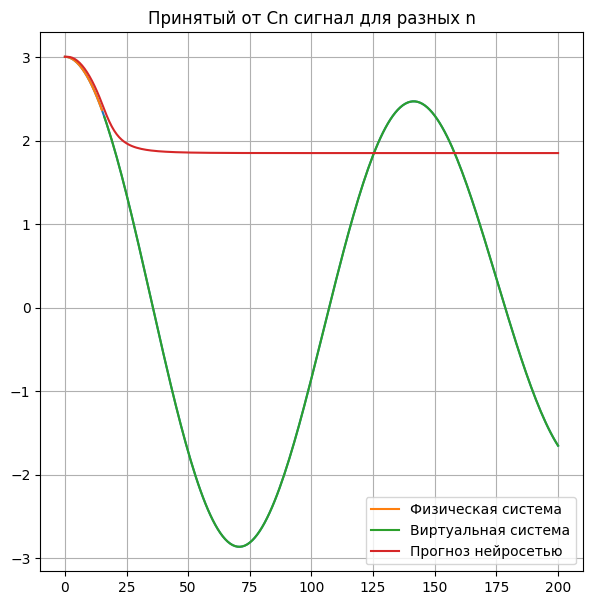

In [430]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, regr_out_Cn[:, -1], label = "Прогноз нейросетью")
plt.legend()
plt.grid()

In [432]:
Result_ar_nn = CnU(a, regr_out_Cn[:, -1])

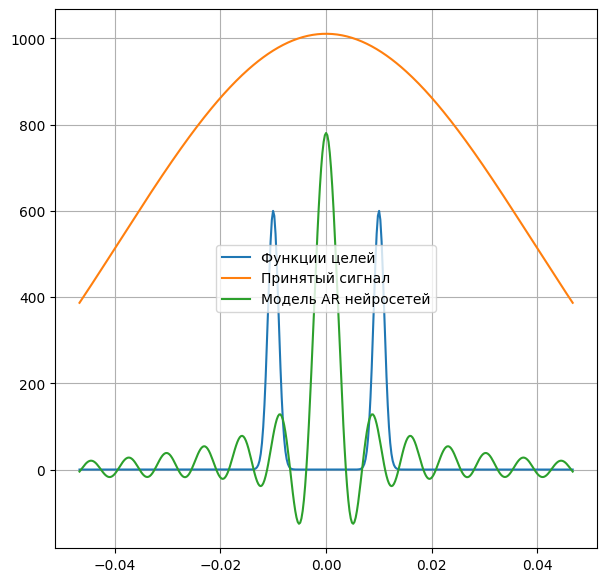

In [434]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result_ar_nn), label = "Модель AR нейросетей")
plt.legend()
plt.grid()
plt.show()